In [12]:
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("/Users/SinglePickle/bosonic-qiskit"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import packages that will be used
import c2qa
import numpy as np
import matplotlib.pyplot as plt
from qiskit import ClassicalRegister, visualization, AncillaRegister
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from math import pi, ceil
from scipy.optimize import curve_fit

# Simulation of the Bosonic Error Correcting Binomial 'Kitten' Code
Z. Liu

#### Contents
1. Introduction
2. Implementation of amplitude damping
3. Implementation of Photon Number Parity Operator
4. Defining error correction gates
5. Implementing arbitrary gates in Bosonic Qiskit
6. Full error correction circuit with Bosonic Qiskit

## Introduction

This tutorial seeks to illustrate how error correction can be done within a Bosonic Qiskit simulation. We will model a circuit undergoing amplitude damping (i.e. photon-loss), with error correction done using the binomial code. In general, binomial codes refer to the family of codes that seek to approximately (to lowest order in error rate) correct photon loss errors. For the purposes of this tutorial, we will describe the simplest binomial code, the 'kitten' code, which uses a single bosonic mode. 

For qubit error correction, code words are the physical qubits that represent our logical states. Redundancy must be introduced when storing our logical information, as successful error correction relies on extracting information from this redundancy to recreate the original error-free state. For qumode error correction, this redundancy can be introduced via code words which store logical information within multiple Fock states. Expressed in the Fock basis, the two code words for the bosonic 'kitten' code are as follows:

\begin{align*}
\ket{0_L} &= \frac{1}{\sqrt{2}} [\ket{0} + \ket{4}] \\
\ket{1_L} &= \ket{2}
\end{align*}

Notice that the average photon excitation for both code words is two. Since the mean rate of photon loss for a damped oscillator is proportion to the photon number, the mean rate of photon loss will be the same in both code words. Additionally, since the code words have even photon number parity, we can define a photon number parity operator for which both code words are the +1 eigenstates.

\begin{align*}
\hat{P} = e^{i \pi a^\dagger a}
\end{align*}

## Implementation of amplitude damping

We can introduce photon loss in Bosonic Qiskit using _PhotonLossNoisePass()_. The noise pass will be applied onto the qumode gates found within __~/bosonic_qiskit/circuit.py__. Bosonic Qiskit requires the user to specify the gate duration since photon loss is a function of time. Though in general, most gates will have a default duration of 100ns.

We can implement amplitude damping via the _cv_delay()_ gate. Since _cv_delay()_ applies the identity operation, it can be used to introduce photon loss without executing additional operations on states within the qumode. The amplitude damping sub-circuit is as follows.

#### (Insert Chart here) ####

In [120]:
## Demonstration of amplitude damping circuit
# Define how many qumodes we want, and how many qubits we should use to represent each. Our basis will consist of Fock states |0> to |7>
num_qumodes = 1
num_qubits_per_qumode = 3 # The photon number which the Hilbert space truncates at is 2 ** num_qubits_per_qumode = 8

# Create circuit
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circ = c2qa.CVCircuit(qmr, cr)

# To illustrate photon loss, first initialize the qumode in Fock state |7>
circ.cv_initialize(7, qmr[0])

# Now apply a delay gate and specify gate duration and units
gate_duration = 100
time_unit = "ns"
circ.cv_delay(duration=gate_duration, qumode=qmr[0], unit=time_unit)

# Now set a loss rate -- make it large enough such that we can actually see the loss
photon_loss_rate = 0.01 # This is a loss rate in units of 1/ns
noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circ, time_unit=time_unit)

# To see the loss, we can make a measurement on the qumode and visualise counts with a histogram
circ.cv_measure(qmr[0], cr)

# Use noise pass with simulate
_, _, counts = c2qa.util.simulate(circ, noise_passes=noise_pass)

# Visualise photon loss using a histogram
visualization.plot_histogram(counts)

Statevector([ 0.00000000e+00+0.j, -1.62030764e-16+0.j,  3.24061528e-16+0.j,
              5.56980751e-17+0.j,  1.00000000e+00+0.j, -1.36257128e-16+0.j,
             -1.17749684e-16+0.j, -2.28836734e-34+0.j],
            dims=(2, 2, 2))


#### (Might remove this section since disretize is still under debugging) ###
Note that _simulate()_ will apply photon loss in one of two ways, depending on whether the _discretize_ flag is set to True or False. 
1. If _discretize = False_, noise will only be applied after gate's operation is complete, and is applied as an approximation.
2. If _discretize = True_, noise will be applied throughout the gate's operation, but simulation will be more computationally expensive.

The default behaviour of _simulate()_ is to set _discretize = False_.

In [4]:
######## SECTION TO COMPLETE ########
# With discretize=True now
state, results, counts = c2qa.util.simulate(circ, noise_passes=noise_pass, discretize=False)

# visualization.plot_histogram(counts)

## Implementation of Photon Number Parity Operator

Bosonic Qiskit does not have a gate that directly measures $\hat{P}$. Hence, we will instead manually implement $\hat{P}$ through phase kickback via the hadamard gate [ $H$ ] and controlled phase space rotation gate [ $\theta(\pi)$ ].

The gates are written as follows:
\begin{align*}
H &= \ket{+}\bra{0} + \ket{-}\bra{1}
\\
\theta(\pi) &= e^{i \frac{\pi}{2} Z \otimes a^\dagger a}
\end{align*}

##### (Insert chart here) ######
![Parity operator circuit](https://github.com/C2QA/bosonic-qiskit/tree/main/tutorials/bosonic-kitten-code/parity_operator_circuit.png)


The derivation for the circuit is as follows:
\begin{align*}
\Psi_1 &= e^{i \frac{\pi}{2} Z \otimes a^\dagger a} ( \hspace{2pt} \ket{+}_{qubit} \otimes \ket{n}_{qumode} \hspace{2pt} ) \\
&= \frac{1}{\sqrt{2}}(\hspace{2pt} \ket{0} \otimes e^{i \frac{\pi}{2} a^\dagger a} \ket{n} + \ket{1} \otimes e^{-i \frac{\pi}{2} a^\dagger a}\ket{n} \hspace{2pt}) \\
&= \frac{e^{i \frac{\pi}{2} a^\dagger a}}{\sqrt{2}} (\hspace{2pt} \ket{0} \otimes \ket{n} + \ket{1} \otimes e^{-i \pi a^\dagger a}\ket{n} \hspace{2pt})
\end{align*}
Up to a global phase, if $\ket{n}$ is odd:
\begin{align*}
\Psi_1 &= (\hspace{2pt} \ket{-} \otimes \ket{n} \hspace{2pt}) \\
\therefore \Psi_2 &= (\hspace{2pt} \ket{1} \otimes \ket{n} \hspace{2pt})
\end{align*}
and if $\ket{n}$ is even,
\begin{align*}
\Psi_1 &= (\hspace{2pt} \ket{+} \otimes \ket{n} \hspace{2pt}) \\
\therefore \Psi_2 &= (\hspace{2pt} \ket{0} \otimes \ket{n} \hspace{2pt})
\end{align*}

In [5]:
## Demonstration of photon parity measurement circuit
# Create new circuit with 1 qumode, 1 ancilla qubit, and 1 classical register for anc readout.
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(1)
circ = c2qa.CVCircuit(qmr, anc, cr)

circ.initialize([1, 0], anc[0]) # Initialize ancilla qubit in |0> state

# Initialize qumode in either odd parity or even parity fock state
#circ.cv_initialize(2, qmr) # |2> Fock state
circ.cv_initialize(3, qmr) # |3> Fock state

# Apply hadamard on ancilla qubit
circ.h(anc[0])

# Apply controlled phase space rotation gate on qumode
circ.cv_c_r(pi/2, qmr[0], anc[0])

# # Apply hadamard on ancilla qubit again, and measure the ancilla qubit.
circ.h(anc[0])
circ.cv_measure(anc, cr)

_, _, counts = c2qa.util.simulate(circ)

# Measurement will return 0 for even parity and 1 for odd parity
print(counts)

{'1': 1024}


/Users/SinglePickle/bosonic-qiskit/venv/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


## Defining error correction gates

For the purposes of this tutorial, we will not go into detail on specific implementations of the error correction gates for the bosonic 'kitten' code. Instead, we will state the expected theoretical state transfer operation that maps the error states back onto our logical qubits.

If parity changes due to photon loss, we expect there to exist a unitary operation with the following mapping. 
\begin{align*}
\ket{E_0} = \ket{3} \rightarrow \ket{0_L} \\
\ket{E_1} = \ket{1} \rightarrow \ket{1_L}
\end{align*}
This corresponds to some theoretical unitary operator $\hat{U}_{odd}$, which can be created using the following set of outer products. The last three elements exist to ensure that the operator is unitary. <br>
$$
\hat{U}_{odd} = \ket{0_L} \bra{E_0} + \ket{1_L}\bra{E_1} + (\frac{\ket{0} - \ket{4}}{\sqrt{2}}) \bra{4} + \ket{1}\bra{0} + \ket{3}\bra{2}
$$

If parity does not change, we instead expect another mapping.
\begin{align*}
\cos{\frac{\theta}{2}}\ket{0_L} + \sin{\frac{\theta}{2}} \ket{E_2} &\rightarrow \ket{0_L}, \hspace{20pt} \ket{E_2} = \frac{\ket{0} - \ket{4}}{\sqrt{2}} \\
\ket{1_L} &\rightarrow \ket{1_L}
\end{align*}
Where to first order, $\cos{\frac{\theta}{2}} \approx 1$ and $\sin{\frac{\theta}{2}} \approx \kappa t$. This corresponds to some unitary operator $\hat{U}_{even}$, which can be created using the following set of outer products. <br>
\begin{align*}
\hat{U}_{even} &= \ket{0_L}[\frac{\hspace{2pt}(1 + \kappa t)\bra{0} + (1 - \kappa t)\bra{4}\hspace{2pt}}{\sqrt{2+2(kt)^2}}] + \ket{E_2} [\frac{\hspace{2pt}(1 - \kappa t)\bra{0} + (1 + \kappa t)\bra{4}\hspace{2pt}}{\sqrt{2+2(kt)^2}}] + \ket{1}\bra{1} + \ket{2}\bra{2} + \ket{3}\bra{3}\\
&= [\frac{\hspace{2pt} \ket{0}\bra{0} + \kappa t \ket{4}\bra{0} - \kappa t \ket{0}\bra{4} + \ket{4}\bra{4} \hspace{2pt}}{\sqrt{1+(kt)^2}}] + \ket{1}\bra{1} + \ket{2}\bra{2} + \ket{3}\bra{3}
\end{align*}

In an actual experiment, these operators may be implemented as a non-trivial series of gates that operate on the state. Although we did not discuss the exact sequence of gates that would be needed to execute these operators, there are functions within Bosonic Qiskit that allows us to specify and append arbitrary gates onto our circuit.

## Implementing arbitrary gates in Bosonic Qiskit

To create the unitary matrix corresponding to our operators $\hat{U}_{odd}$ and $\hat{U}_{even}$, we can use the _fockmap()_ helper function. Instead of creating the matrix by manually filling out the individual elements within an array, the helper function allows you to create the matrix by specifying the mapping between the desired set of input and output Fock states. This is helpful for cases where the operator you want to specify is already written in the Fock basis. Note that _fockmap()_ function is intended for generating single qumodes gates only.

In [6]:
# Create empty matrix
empty = np.zeros((2**num_qubits_per_qumode, 2**num_qubits_per_qumode))

## Defining our theoretical operation for U_odd
# Map logical 1's photon loss state |1> back to logical 1. (i.e. |2><1|, where fock_input = <1|, and fock_output = |2>)
u_odd = c2qa.util.fockmap(matrix=empty, fock_input=[1], fock_output=[2]) 

# Map logical 0's photon loss state |3> to logical 0
u_odd = c2qa.util.fockmap(u_odd, fock_input=[3, 3], fock_output=[0, 4], amplitude=[1/np.sqrt(2), 1/np.sqrt(2)]) 

# Mappings to satisfy unitary condition
u_odd = c2qa.util.fockmap(u_odd, [5, 6, 7], [5, 6, 7])
u_odd = c2qa.util.fockmap(u_odd, [2, 0], [3, 1]) 
u_odd = c2qa.util.fockmap(u_odd, [4, 4], [0, 4], 1/np.sqrt(2) * np.array([1, -1]))

# Check that our matrix is indeed unitary
assert(is_unitary_matrix(u_odd))

## Defining our theoretical operation for U_even. 
# We will delay the building of the gate until we have the value we need for kt
def u_even(kt):
    # Map logical 1 back to logical 1
    u_even = c2qa.util.fockmap(empty, 2, 2) 

    # Map logical 0's error state to logical 0
    u_even = c2qa.util.fockmap(u_even, [0, 0, 4, 4], [0, 4, 0, 4], 1/np.sqrt(1 + kt**2) * np.array([1, kt, -kt, 1])) 

    # Mappings to satisfy unitary condition
    u_even = c2qa.util.fockmap(u_even, [1, 3, 5, 6, 7], [1, 3, 5, 6, 7]) 

    # Check that our matrix is indeed unitary
    assert(is_unitary_matrix(u_even))
    return u_even

Now that we have created the matrices corresponding to our operators, we can then append the matrices to the circuit using the _cv_gate_from_matrix()_ function. This is essentially a version of Qiskit's _circuit.unitary()_ method that works with bosonic circuits.

In [7]:
# Initialize new circuit 
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
cr = ClassicalRegister(num_qumodes * num_qubits_per_qumode)
circ = c2qa.CVCircuit(qmr, cr)

# Initialize qumode in |1_L> error state
circ.cv_initialize([0, 1], qmr)

# Append the u_odd matrix to circuit and measure
circ.cv_gate_from_matrix(u_odd, qmr[0])
circ.cv_measure(qmr[0], cr)

_, _, counts = c2qa.util.simulate(circ)

# We measure |2> Fock state, demonstrating recovery of the logical 1 state
print(counts)

{'2': 1024}


Note that because the operators that we defined in this tutorial (u_odd, u_even) are gates which would normally be implemented by multiple successive gates, Bosonic Qiskit functions such as _simulate(discretize=True)_ with _PhotonLossNoisePass()_ applied, or _animate_wigner()_ may not be executed in a way that is accurate or physical. For better control over noise application within Bosonic Qiskit simulations, it is recommended to decompose your _cv_gate_from_matrix()_ operators to a set of gates that can be physically realized.

## Full error correction circuit with Bosonic Qiskit

Now that we have explained the individual parts of the error correction circuit, we can move on to create the full error correction circuit. The simulation can be repeated with varying parameters to demonstrate the effect of the error correction code. Snapshots of the state are automatically taken after each correction, but additional snapshots can be scheduled in between corrections.

__Assumptions__: 
1. All gates will execute perfectly with no coherent errors. State preparation and readout will also be free of errors.
2. The dominant error in the circuit is photon loss on the qumode. Hence, we will ignore all other incoherent errors in this simulation.  
3. The photon loss rate is callibrated such that the logical qubit has a lifetime of ~1ms without corrections.
4. Parity measurement will take 3µs in total to execute, while recovery operation is instantaneous. Photon loss may occur during the parity measurement.

In [115]:
## Run this block to load in the functions we need for the simulation

# Runs circuit simulation
def error_correction_experiment(encoding: str, corrections: int, shots: int, additional_snapshots: int=10, total_circuit_time: int=1, apply_noise: bool=True, return_circuit: bool=False, had_damp: bool=False):
    multiplier = total_circuit_time
    total_circuit_time = int(total_circuit_time * 1000) # Code works with microsecond units, but input is in milliseconds
    
    if corrections > 333:
        raise ValueError("Please restrict number of correction procedures to 333 or less")
    photon_loss_rate = 0.0005
    
    if encoding == 'logi0':
        logi0, logi1, best = True, False, False
    elif encoding == 'logi1':
        logi0, logi1, best = False, True, False
    elif encoding == '01':
        logi0, logi1, best = False, False, True
    else:
        raise ValueError("Please input either \'logi0\' or \'logi1\' for the encoding")

    num_qumodes = 1
    num_qubits_per_qumode = 3

    qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
    anc = AncillaRegister(1)
    cr = ClassicalRegister(1)
    circuit = c2qa.CVCircuit(qmr, anc, cr)

    ### 1. State Preparation
    if logi0:
        circuit.cv_initialize(1/np.sqrt(2)*np.array([1, 0, 0, 0, 1]), qmr[0])
    elif logi1:
        circuit.cv_initialize([0, 0, 1], qmr[0])
    elif best:
        circuit.cv_initialize([0, 1], qmr[0])

    ### 2. Using instructions stored in schedule, add snapshots, noise, and parity check + recovery operations
    schedule = _circuit_scheduler(corrections * multiplier, additional_snapshots * multiplier, total_circuit_time)
    schedule_copy = list(schedule.items())

    adjustment = 0 # For calculating duration timing
    snapshot_counter = 0 # For tracking number of snapshots taken
    corr_position = [] # For tracking positions at which corrections were finished
    
    for index, (key, value) in enumerate(list(schedule.items())):
        # Instruction at 0µs should always be to take snapshot
        if (key == '0') & (value == 'snapshot'):
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            continue
        elif (key != '0'):
            pass
        else:
            raise Exception("Something seems to have gone wrong here")

        # Calculate delay gate durations using prevkey. Adjustment to duration timing is needed depending on previous instruction
        prevkey, prevvalue = schedule_copy[index - 1]
        delay_dur = int(key) - int(prevkey) + adjustment
        adjustment = 0

        # Apply noise
        circuit.cv_delay(duration=delay_dur, qumode=qmr[0], unit="µs")

        # Apply snapshot only procedure
        if (value == 'snapshot'):
            if (prevvalue == 'correction') & (int(key) == (int(prevkey) + 3)):
                pass
            else:
                circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
                snapshot_counter += 1

        # Apply correction first followed by snapshot 
        elif value == 'correction':
            kt = photon_loss_rate * (delay_dur + 3)
            adjustment = -3

            # Parity check
            circuit.initialize([1, 0], anc[0])
            circuit.h(anc[0])
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            
            for _ in range(10): # Manually discretize cv_c_r gate by splitting one 1µs pi/2 rotation into ten 0.1µs pi/20 rotations
               circuit.cv_c_r(pi/20, qmr[0], anc[0], duration=0.1, unit="µs")
            #circuit.cv_c_r(pi/2, qmr[0], anc[0], duration=1, unit="µs")
            
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            circuit.h(anc[0])
            circuit.measure(anc[0], cr[0])

            # Recovery operation
            with circuit.if_test((cr[0], 1), label='Recovery op') as else_:
                circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0)
                circuit.reset(anc[0])
            with else_:
                circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0)
            
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            corr_position.append(int(key) + 3)

        # Apply snapshot first followed by correction, followed by another snapshot
        else:
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            
            adjustment = -3
            kt = photon_loss_rate * (delay_dur + 3)

            # Parity check
            circuit.initialize([1, 0], anc[0])
            circuit.h(anc[0])
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            
            for _ in range(10): # Manually discretize cv_c_r gate by splitting one 1µs pi/2 rotation into ten 0.1µs pi/20 rotations
                circuit.cv_c_r(pi/20, qmr[0], anc[0], duration=0.1, unit="µs")
            #circuit.cv_c_r(pi/2, qmr[0], anc[0], duration=1, unit="µs")
            
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            circuit.h(anc[0])
            circuit.measure(anc[0], cr[0])

            # Recovery operation
            with circuit.if_test((cr[0], 1), label='Recovery op') as else_:
                circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0)
                circuit.reset(anc[0])
            with else_:
                circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0)
                
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            corr_position.append(int(key) + 3)

    # Final delay gate
    finalkey, finalvalue = schedule_copy[-1]
    if finalvalue != 'snapshot':
        final_gate_delay = total_circuit_time - int(finalkey) - 3
    else:
        final_gate_delay = total_circuit_time - int(finalkey)
        
    circuit.cv_delay(duration=final_gate_delay, qumode=qmr[0], unit="µs")
    
    if return_circuit:
        return circuit
    
    ### 3. Define noise parameters
    # Noise pass for qumode photon loss
    noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="µs")

    # Noise model for hadamard amplitude damping
    T1 = 10 # In µs
    hgate_duration = 1 # In µs
    error = amplitude_damping_error(1 - np.exp(-hgate_duration / T1))

    noise_model = NoiseModel()
    index, _ = circuit.find_bit(anc[0])
    noise_model.add_quantum_error(error, ['h'], [index])
    
    ### 4. Simulate circuit
    if apply_noise:
        if had_damp:
            state, result, _ = c2qa.util.simulate(circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False, noise_passes=noise_pass, noise_model=noise_model)
        else:
            state, result, _ = c2qa.util.simulate(circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False, noise_passes=noise_pass)
    elif not apply_noise:
        state, result, _ = c2qa.util.simulate(circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False)
    
    ### 5. Process data
    # Find fidelity and photon probability at each snapshot, across all shots
    state_fidelity, state_probability = _state_processor(encoding, circuit, state, result, snapshot_counter, shots)
    #avg_fidelity, avg_fid_std, avg_probability, avg_prob_std = _state_processor(encoding, circuit, state, result, snapshot_counter, shots)
    
    # Find exact timing of each snapshot (we have to recalculate because no. of snapshots can change due to scheduling conflicts)
    snapshot_times = _snapshot_timings(schedule, total_circuit_time)

    return state_fidelity, state_probability, snapshot_times, corr_position
    #return (avg_fidelity, avg_fid_std), (avg_probability, avg_prob_std), snapshot_times, corr_position# circuit, schedule, snapshot_counter


# Takes results from simulation and processes data to find average fidelity and average photon probability of state
def _state_processor(encoding, circuit, state, result, actual_snapshots, shots):
    if encoding == 'logi0':
        logi0, logi1, best = True, False, False
    elif encoding == 'logi1':
        logi0, logi1, best = False, True, False
    elif encoding == '01':
        logi0, logi1, best = False, False, True

    # 1. Process snapshot and final statevectors. Trace out qumode from circuit for both sets of statevectors
    traced_snapshot_density_matrices = []
    for i in range(actual_snapshots):
        snapshot_list = result.data()['snapshot_{}'.format(i)]

        traced_snapshots = []
        for statevector in snapshot_list:
            traced_snapshots.append(c2qa.util.trace_out_qubits(circuit, statevector))

        traced_snapshot_density_matrices.append(traced_snapshots)

    traced_final_density_matrices = []
    for i in state:
        traced_final_density_matrices.append(c2qa.util.trace_out_qubits(circuit, i))
    
    traced_density_matrices = traced_snapshot_density_matrices + [traced_final_density_matrices]

    # 2. Create statevectors corresponding to our code words
    perf_0 = Statevector([1/np.sqrt(2), 0, 0, 0, 1/np.sqrt(2), 0, 0, 0])
    perf_1 = Statevector([0, 0, 1, 0, 0, 0, 0, 0])
    perf_best = Statevector([0, 1, 0, 0, 0, 0, 0, 0])

    # 3. Compute from each density matrix 1) fidelity, 2) probability of measuring each photon number, 3) average photon number
    fidelity_list, probability_list, avg_photon_list = [], [], []
    for density_matrix_list in traced_density_matrices:
        
        cycle_list_fid, cycle_list_prob, cycle_list_avg_photon = [], [], []
        for matrix in density_matrix_list:
            # Fid
            if logi0:
                cycle_list_fid.append(round(state_fidelity(matrix, perf_0), 6))
            elif logi1:
                cycle_list_fid.append(round(state_fidelity(matrix, perf_1), 6))
            elif best:
                cycle_list_fid.append(round(state_fidelity(matrix, perf_best), 6))
            
            # Photon meas prob
            state_prob = list(matrix.probabilities(decimals=2))
            cycle_list_prob.append(state_prob)
            
            # Avg photon num
            #cycle_list_avg_photon.append(c2qa.util.avg_photon_num(matrix))

        fidelity_list.append(cycle_list_fid)
        probability_list.append(cycle_list_prob)
        #avg_photon_list.append(cycle_list_avg_photon)

    # Average results across all shots
    #avg_fid = [round(np.average(cycle), 4) for cycle in fidelity_list]
    #avg_fid_std = [round(np.std(cycle)/np.sqrt(shots), 4) for cycle in fidelity_list]
    
    #avg_prob = [np.mean(i, axis=0) for i in probability_list]
    #avg_prob_std = [np.std(i, axis=0)/np.sqrt(shots) for i in probability_list]
    #avg_photon = [round(np.average(cycle), 4) for cycle in avg_photon_list]
    
    return fidelity_list, probability_list#, avg_fid, avg_fid_std, avg_prob, avg_prob_std#, avg_photon


# Function used to determine order and timing in which snapshots and corrections are done.
def _circuit_scheduler(corrections, snapshots, total_time=1000):
    # Schedule snapshots
    snapshot_schedule = {"{}".format(round(i * (total_time/snapshots))): 'snapshot' for i in range(snapshots)}

    # Schedule corrections
    corr_interval = total_time/(1 + corrections)
    correction_schedule = {"{}".format(int((i + 1) * corr_interval)): 'correction' for i in range(corrections)}
        
    # Merge the two dicts from above. If duplicate keys exist then concatenate values together.
    try:
        unsorted_merged_schedule = {**snapshot_schedule, **correction_schedule}

        for key, value in list(snapshot_schedule.items()):
            if key in list(correction_schedule.keys()):
                unsorted_merged_schedule[key] = '{}'.format(value + '+' + correction_schedule[key])
            else:
                pass
    # If correction_schedule doesn't exist, return snapshot_schedule
    except:
        return snapshot_schedule
    
    # Sort merged dicts
    merged_schedule = {key:value for key, value in sorted(unsorted_merged_schedule.items(), key=lambda item: int(item[0]))}

    # Ensure that all corrections happen at least 3µs before each snapshot
    # but if two successive corrections happen within 3µs of each other, drop the second correction
    DictItems = list(merged_schedule.items())
    unsorted_cleaned_schedule = dict(merged_schedule)
    for index, (key, value) in enumerate(DictItems):
        # index == 0 case
        if index == 0:
            nextkey, _ = DictItems[index + 1]
            if (value == 'correction') & (int(key) + 3 > int(nextkey)):
                unsorted_cleaned_schedule['{}'.format(str(int(nextkey) - 3))] = unsorted_cleaned_schedule.pop('{}'.format(key))
        # index != 0 case
        else:
            # Automatically break loop when we get to last element of dictionary
            try:
                nextkey, _ = DictItems[index + 1]
                prevkey, _ = DictItems[index - 1]
            except:
                break
            
            if (value == 'correction') & (int(key) + 3 > int(nextkey)) & (int(prevkey) < int(key) - 3):
                unsorted_cleaned_schedule['{}'.format(str(int(nextkey) - 3))] = unsorted_cleaned_schedule.pop('{}'.format(key))
            elif (value == 'correction') & (int(key) + 3 > int(nextkey)):
                unsorted_cleaned_schedule.pop('{}'.format(key))
                print("Due to scheduling conflicts, a correction scheduled at {}µs will be dropped".format(key))

    # Sort overall_schedule
    cleaned_schedule = {key:value for key, value in sorted(unsorted_cleaned_schedule.items(), key=lambda item: int(item[0]))}

    return cleaned_schedule

# Function for extracting snapshot timings (in ms)
def _snapshot_timings(schedule, total_circuit_time):
    timings = []
    sch_copy = list(schedule.items())
    prevkey, prevvalue = 0, 0 # Just so that first iteration doesn't throw an error
    
    for index, (key, value) in enumerate(list(schedule.items())):
        if index != 0:
            prevkey, prevvalue = sch_copy[index - 1]
        
        if value == 'snapshot':
            if (prevvalue == 'correction') & (int(key) == (int(prevkey) + 3)):
                pass
            else:
                timings.append(int(key)/1000)
            
        elif value =='correction':
            timings.append((int(key) + 3)/1000)
        else:
            timings.append(int(key)/1000)
            timings.append((int(key) + 3)/1000)
            
    timings.append(total_circuit_time/1000)
    
    return timings

# Function for extracting positions where corrections were done
def correction_positions(corr_positions, correction_avg_fidelity, correction_snapshot_timings):
    corr_time = [key/1000 for key in corr_positions]
    corr_fid = [correction_avg_fidelity[correction_snapshot_timings.index(timing)] for timing in corr_time]
    
    return corr_time, corr_fid

# Function for fitting exponential curve
def curve_fitter(x, y):
    popt, pcov = curve_fit(lambda x, b: np.exp(-x/b), x, y)
    sigma = np.sqrt(np.diag(pcov))
    
    lifetime = round(popt[0], 2)
    uncertainty = round(sigma[0], 2)
    
    return lifetime, uncertainty

The basic structure of the circuit that we will simulate is as follows. 

##### (Insert chart here) #####

Since the circuit is dynamically generated based on the values of the six paramters below, the specific layout of the circuit that is simulated can be accessed by uncommenting the last few lines of the cell below. The simulation will return two types of measurements for each state snapshot: 1) the state fidelity as computed against the initial state, and 2) the probability of measuring a particular Fock state. 

In [116]:
### Adjust these parameters ###
num_corr = 2 # per ms, number of corrections done
additional_snaps = 4 # per ms, number of additional snapshots taken

noise_only_circ_time = 1 # ms, total duration of noise_only circuit
correction_circ_time = 1 # ms, total duration of correction circuit

shots = 1000 # Number of times circuit is repeated
encoding='logi0' # Input 'logi0' or 'logi1' only
## 

# Run simulation with and without correction
noise_only_fid, noise_only_prob, noise_only_snapshot_timings, _ = error_correction_experiment(encoding, 0, shots, additional_snaps, noise_only_circ_time)
correction_fid, correction_prob, correction_snapshot_timings, corr_position_times = error_correction_experiment(encoding, num_corr, shots, additional_snaps, correction_circ_time)
# noise_only_avg_fid_tuple, noise_only_avg_prob_tuple, noise_only_snapshot_timings, _ = error_correction_experiment(encoding, 0, shots, additional_snaps, noise_only_circ_time)
# correction_avg_fid_tuple, correction_avg_prob_tuple, correction_snapshot_timings, corr_position_times = error_correction_experiment(encoding, num_corr, shots, additional_snaps, correction_circ_time)

# To generate the circuit diagram for the simulations, uncomment these lines
# noise_circuit = error_correction_experiment(encoding, 0, shots, additional_snaps, noise_only_circ_time, return_circuit=True)
# correction_circuit = error_correction_experiment(encoding, num_corr, shots, additional_snaps, correction_circ_time, return_circuit=True)

# noise_circuit.draw()
# correction_circuit.draw()

To properly characterize the state fidelity results, we will first look at the distribution of fidelity values for every snapshot using sub-plots, before looking at the trajectory of the average fidelity across all shots over the duration of the circuit.

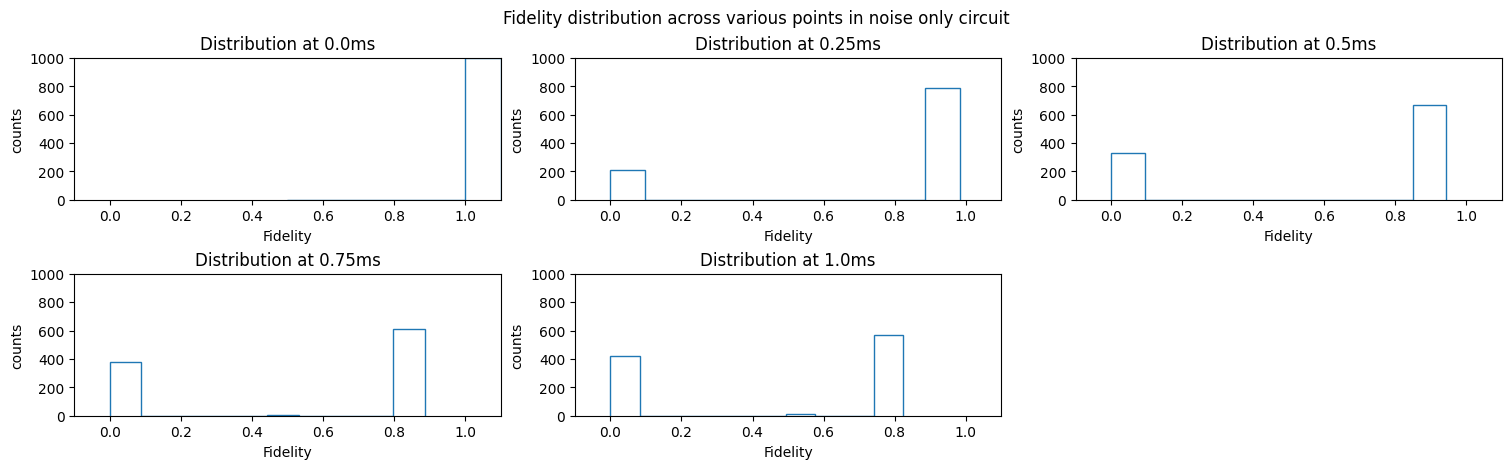

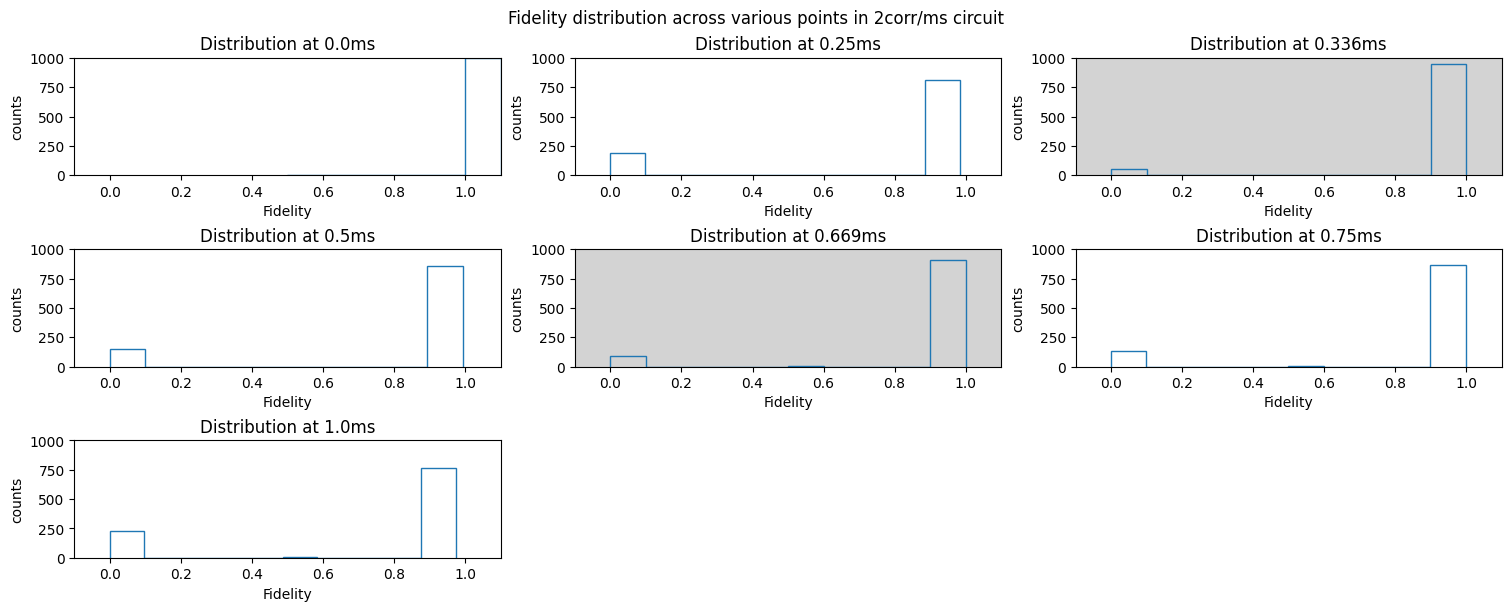

In [117]:
## Fidelity distribution plotting
entries = ceil(np.sqrt(len(noise_only_snapshot_timings)))

fig = plt.figure(figsize=(15,6), layout='constrained')
fig.suptitle("Fidelity distribution across various points in noise only circuit")

#fig.add_axes(sharex=True)
#plt.subplots(nrows=entries, ncols=entries, figsize=(15, 6), sharex=True, sharey=True)
for index, timing in enumerate(noise_only_snapshot_timings):
    plt.subplot(entries, entries, (index + 1), title="Distribution at {}ms".format(timing), ylabel="counts", xlabel ="Fidelity", ylim=(0, 1000), xlim=(-0.1, 1.1))
    counts, bins = np.histogram(noise_only_fid[index])
    plt.stairs(counts, bins)

# plt.supxlabel("Fidelity")
# plt.supylabel("Count")
plt.show()


entries = ceil(np.sqrt(len(correction_snapshot_timings)))

fig = plt.figure(figsize=(15,6), layout='constrained')
fig.suptitle("Fidelity distribution across various points in 2corr/ms circuit")

#fig.add_axes(sharex=True)
#plt.subplots(nrows=entries, ncols=entries, figsize=(15, 6), sharex=True, sharey=True)
for index, timing in enumerate(correction_snapshot_timings):
    if any(timing * 1000 == corr_position for corr_position in corr_position_times):
        plt.subplot(entries, entries, (index + 1), title="Distribution at {}ms".format(timing), ylabel="counts", xlabel ="Fidelity", facecolor='lightgrey', ylim=(0, 1000), xlim=(-0.1, 1.1))
    else:
        plt.subplot(entries, entries, (index + 1), title="Distribution at {}ms".format(timing), ylabel="counts", xlabel ="Fidelity", ylim=(0, 1000), xlim=(-0.1, 1.1))
    counts, bins = np.histogram(correction_fid[index])
    plt.stairs(counts, bins)

# plt.supxlabel("Fidelity")
# plt.supylabel("Count")
plt.show()


The trajectory of the state fidelity is plotted using Matplotlib. The fidelity data is fitted with $f(t) = e^{-t/\tau}$, where $\tau$ is a constant representing the lifetime of the logical qubit. The specific locations at which corrections were done are marked by red boxes.

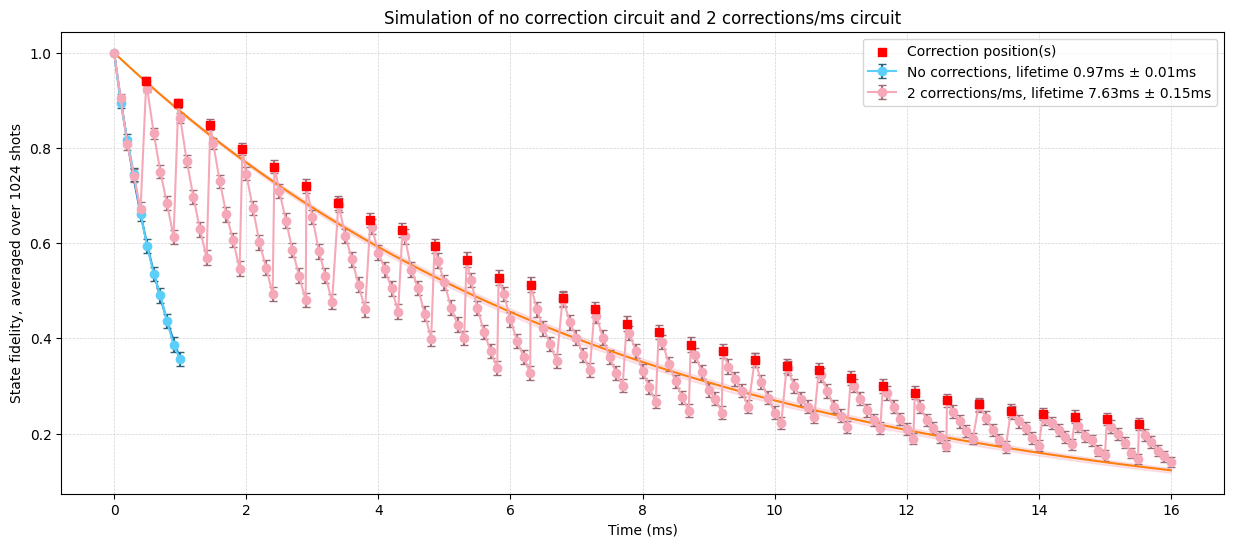

In [22]:
## Fidelity visualisation
noise_only_avg_fid, noise_only_avg_fid_uncert = noise_only_avg_fid_tuple
correction_avg_fid, correction_avg_fid_uncert = correction_avg_fid_tuple

# Fit fidelity data using an exponential decay function
noise_only_lifetime, noise_lifetime_uncertainty = curve_fitter(noise_only_snapshot_timings, noise_only_avg_fid)
correction_lifetime, correction_lifetime_uncertainty = curve_fitter(correction_snapshot_timings, correction_avg_fid)

# Plot fidelity data w/ uncertainty
plt.figure(figsize=(15,6))
plt.errorbar(noise_only_snapshot_timings, noise_only_avg_fid, yerr=noise_only_avg_fid_uncert,
         label="No corrections, lifetime {}ms ± {}ms".format(noise_only_lifetime, noise_lifetime_uncertainty), marker='o', color='#5BCEFA', capsize=3, ecolor='#2a6278')
plt.errorbar(correction_snapshot_timings, correction_avg_fid, yerr=correction_avg_fid_uncert,
         label="{} corrections/ms, lifetime {}ms ± {}ms".format(num_corr, correction_lifetime, correction_lifetime_uncertainty), marker='o', color='#F5A9B8', capsize=3, ecolor='#9c6b75')

# Plot curve fits w/ uncertainty
noise_curve_timing = np.linspace(0, noise_only_circ_time, 100)
plt.plot(noise_curve_timing, np.exp(-noise_curve_timing/noise_only_lifetime))
plt.fill_between(noise_curve_timing, np.exp(-noise_curve_timing/(noise_only_lifetime + noise_lifetime_uncertainty)), 
                 np.exp(-noise_curve_timing/(noise_only_lifetime - noise_lifetime_uncertainty)), color='#5BCEFA', alpha=0.3)

corr_curve_timing = np.linspace(0, correction_circ_time, 100)
plt.plot(corr_curve_timing, np.exp(-corr_curve_timing/correction_lifetime))
plt.fill_between(corr_curve_timing, np.exp(-corr_curve_timing/(correction_lifetime + correction_lifetime_uncertainty)), 
                 np.exp(-corr_curve_timing/(correction_lifetime - correction_lifetime_uncertainty)), color='#F5A9B8', alpha=0.3)

# Plot correction positions
x, y = correction_positions(corr_position_times, correction_avg_fid, correction_snapshot_timings)
plt.scatter(x, y, marker = 's', label = "Correction position(s)", color = 'red', zorder=3)

plt.xlabel("Time (ms)")
plt.ylabel("State fidelity, averaged over {} shots".format(shots))
plt.title("Simulation of no correction circuit and {} corrections/ms circuit".format(num_corr))
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.legend(loc='upper right')
plt.show()

The trajectories of the Fock state probability are plotted using Matplotlib. The trajectories for the 'no correction' run and the 'with correction' run are plotted on separate graphs. The specific locations at which corrections were done are marked by grey dashed lines.

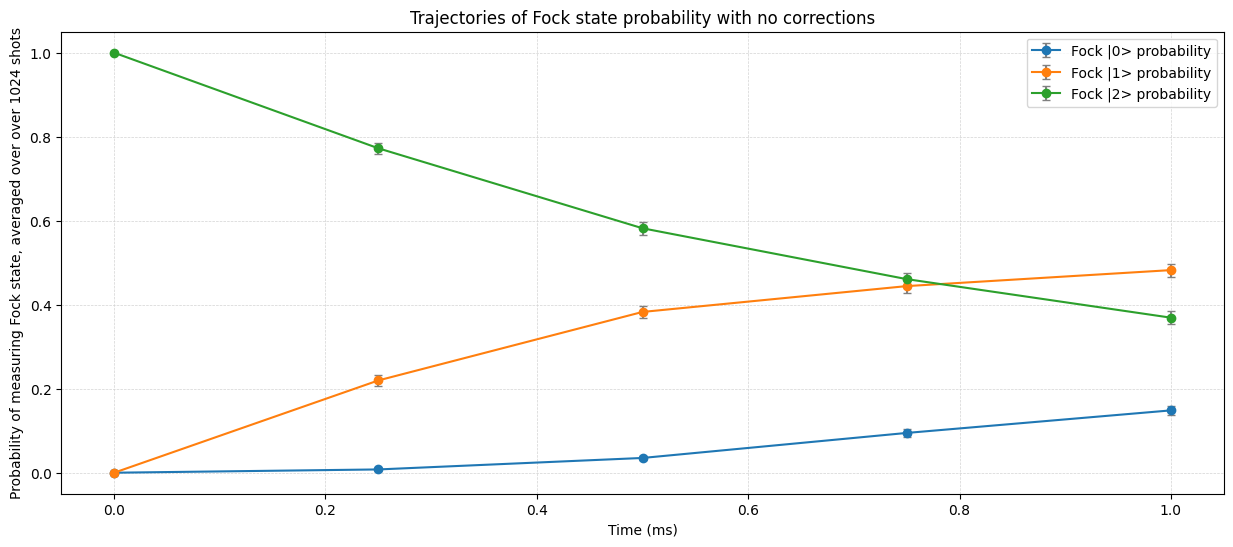

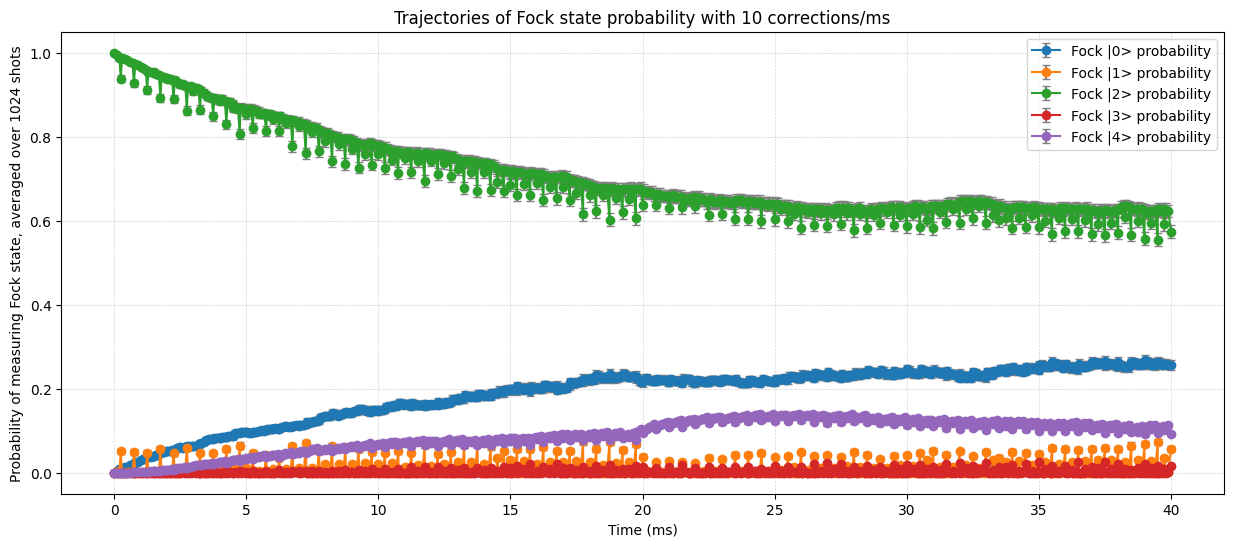

In [14]:
## Fock state visualisation
noise_only_avg_prob, noise_only_avg_prob_uncert = noise_only_avg_prob_tuple
correction_avg_prob, correction_avg_prob_uncert = correction_avg_prob_tuple

# Ignore trajectories of Fock states with prob below a certain value.
prob_truncation = 0.01

# Plot Fock state distribution for noise only circuit
plt.figure(figsize=(15,6))
n,  = noise_only_avg_prob[0].shape
for index in range(n):
    trajectory = [value[index] for value in noise_only_avg_prob]
    uncert = [value[index] for value in noise_only_avg_prob_uncert]
    if all(i == 0 for i in trajectory):
        continue
    plt.errorbar(noise_only_snapshot_timings, trajectory, yerr=uncert, marker='o', label="Fock |{}> probability".format(index), capsize=3, ecolor='grey')
    
plt.xlabel("Time (ms)")
plt.ylabel("Probability of measuring Fock state, averaged over over {} shots".format(shots))
plt.title("Trajectories of Fock state probability with no corrections")
plt.legend(loc='upper right')
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.show()

# Plot Fock state distribution for correction circuit
plt.figure(figsize=(15,6))
n,  = correction_avg_prob[0].shape
for index in range(n):
    trajectory = [value[index] for value in correction_avg_prob]
    uncert = [value[index] for value in correction_avg_prob_uncert]
    if all(i <= prob_truncation for i in trajectory):
        continue
    plt.errorbar(correction_snapshot_timings, trajectory, yerr=uncert, marker='o', label="Fock |{}> probability".format(index), capsize=3, ecolor='grey')
    
# # Plot correction positions
# x, y = correction_positions(corr_position_times, correction_avg_prob, correction_snapshot_timings)
# label = 'Correction Position'
# for i in x:
#     plt.axvline(x=i, color='grey', label=label, linestyle="--")
#     label = ''

plt.xlabel("Time (ms)")
plt.ylabel("Probability of measuring Fock state, averaged over {} shots".format(shots))
plt.title("Trajectories of Fock state probability with {} corrections/ms".format(num_corr))
plt.legend(loc='upper right')
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.show()

To better visualize the effect of number of corrections on state fidelity, the simulation is repeated while varying the number of corrections/ms. State fidelity trajectory and its corresponding curve fit will be plotted for each repeat.

1 Run starting
2 Run starting
3 Run starting
4 Run starting
5 Run starting
6 Run starting
7 Run starting
8 Run starting
9 Run starting


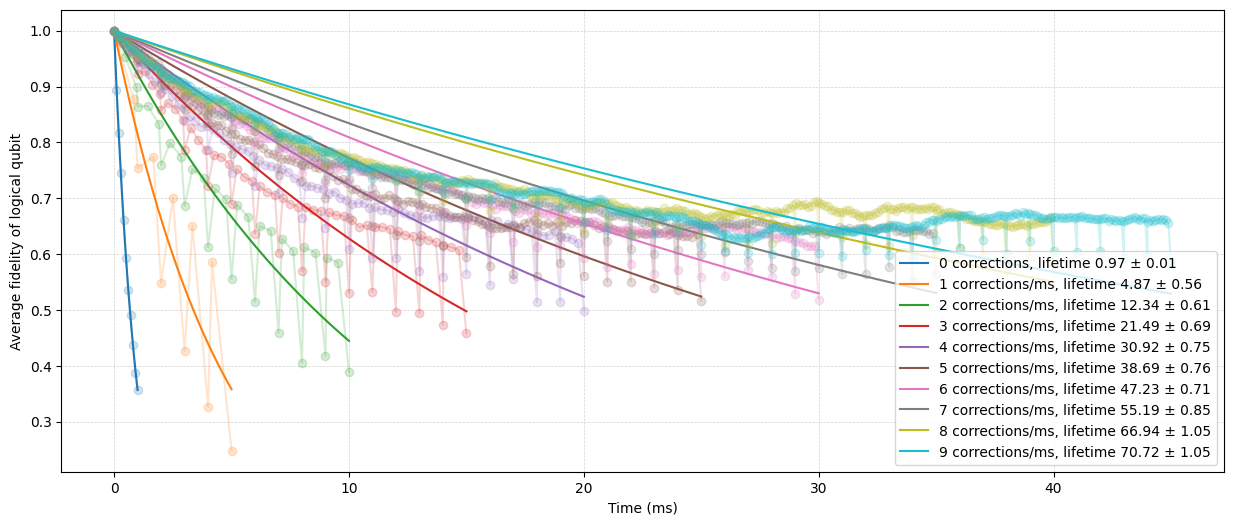

In [23]:
# Compute exponential fit across a variety of corrections
num_corr = [(i + 1) * 1 for i in range(9)]
correction_circ_time = [(i + 1) * 5 for i in range(9)] #[(i + 1) * 8 for i in range(5)]
additional_snaps = 1
shots = 1024
encoding='logi1' # Input 'logi0' or 'logi1' only

# Colors for plotting
colors= ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot noise_only trial as simulated above
plt.figure(figsize=(15,6))
plt.plot(noise_only_snapshot_timings, noise_only_avg_fid, marker='o', color='#1f77b4', alpha=0.2)
plt.plot(noise_curve_timing, np.exp(-noise_curve_timing/noise_only_lifetime), label="0 corrections, lifetime {} ± {}".format(noise_only_lifetime, noise_lifetime_uncertainty), color='#1f77b4')

# Plot all other correction trials w/ lifetimes
for index, corrections in enumerate(num_corr):
    print(corrections, "Run starting")
    correction_avg_fid_tuple, _, correction_snapshot_timings, corr_position_times = error_correction_experiment(encoding, corrections, shots, additional_snaps, correction_circ_time[index])
    correction_avg_fid, _ = correction_avg_fid_tuple
    lifetime, lifetime_uncertainty = curve_fitter(correction_snapshot_timings, correction_avg_fid)
    
    # If lifetime uncertainty is too high, repeat run
    # counter = 0
    # while lifetime_uncertainty >= 0.5:
    #     print(corrections, "Run repeating")
    #     correction_avg_fid_tuple, _, correction_snapshot_timings, corr_position_times = error_correction_experiment(encoding, corrections, shots, additional_snaps, correction_circ_time[index])
    #     correction_avg_fid, _ = correction_avg_fid_tuple
    #     lifetime, lifetime_uncertainty = curve_fitter(correction_snapshot_timings, correction_avg_fid)
    #     counter += 1
    #     if counter >= 3:
    #         break
    
    curve_timing = np.linspace(0, correction_circ_time[index], 100)
    plt.plot(correction_snapshot_timings, correction_avg_fid, marker='o', color=colors[index], alpha=0.2)
    plt.plot(curve_timing, np.exp(-curve_timing/lifetime), label="{} corrections/ms, lifetime {} ± {}".format(num_corr[index], lifetime, lifetime_uncertainty), color=colors[index])

plt.xlabel("Time (ms)")
plt.ylabel("Average fidelity of logical qubit")
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.legend()
plt.show()

Finally, we can compute the gain while varying the number of corrections/ms. The gain is defined as the ratio between the lifetime of the corrected logical qubit, and the logical qubit with the longest lifetime in the circuit. The encoding that results in a logical qubit with the longest lifetime would be one that minimizes the average photon number. 

#### (How would I track lifetime of 0 state. This sim doesn't support T2, won't the 0 state just go on forever?)

\begin{align*}
\ket{long} = \frac{\ket{0} + \ket{1}}{\sqrt{2}} ??
\end{align*}

For our circuit, the logical qubit with the longest lifetime would be 
\begin{align*}
\text{gain} = \frac{\tau_{correction}}{\tau_{longest}}
\end{align*}
Since we did not include coherent errors within our simulation, we expect that the gain of the circuit will always be above 1. The gain of the circuit should also increase as the number of corrections done increases.

In [10]:
## This is an expensive computation to run. Do not try to run this code block unless your computer is very powerful.

# Compute gain across a variety of corrections
num_corr = [(i + 1) * 10 for i in range(10)]
correction_circ_time = [(i + 1) * 30 for i in range(10)]

num_corr = num_corr[7:]
correction_circ_time = correction_circ_time[7:]

additional_snaps = 10
shots = 1024
encoding='logi1' # Input 'logi0' or 'logi1' only

# Simulate noise-only experiment and calculate lifetime constant
noise_only_avg_fid, noise_only_snapshot_timings, _ = error_correction_experiment(encoding, 0, shots, additional_snaps, 1)
noise_only_lifetime = curve_fitter(noise_only_snapshot_timings, noise_only_avg_fid)

# Simulate corrections
gain = []
actual_corrections = []
error_bar = []
for index, corrections in enumerate(num_corr):
    try:
        correction_avg_fid, correction_snapshot_timings, corr_position_times = error_correction_experiment(encoding, corrections, shots, additional_snaps, correction_circ_time[index])
    except Exception as e:
        print(e)
        print("Experiment for {} corrections was unable to execute".format(corrections))
        gain.append(0)
        actual_corrections.append(corrections/correction_circ_time[index])

    # Fit data and compute gain from lifetime
    lifetime, uncertainty = curve_fitter(correction_snapshot_timings, correction_avg_fid)
    gain.append(lifetime/noise_only_lifetime)
    error_bar.append(uncertainty)
    print(lifetime, uncertainty, corrections)

    # Calculate actual number of corrections done
    x, y = correction_positions(corr_position_times, correction_avg_fid, correction_snapshot_timings)
    actual_corrections.append(len(x)/correction_circ_time[index])
    
    # counter = 0
    # for key, value in list(schedule.items()):
    #     if value != 'snapshot':
    #         counter+= 1
    
    # actual_corrections.append(counter)

: 

: 

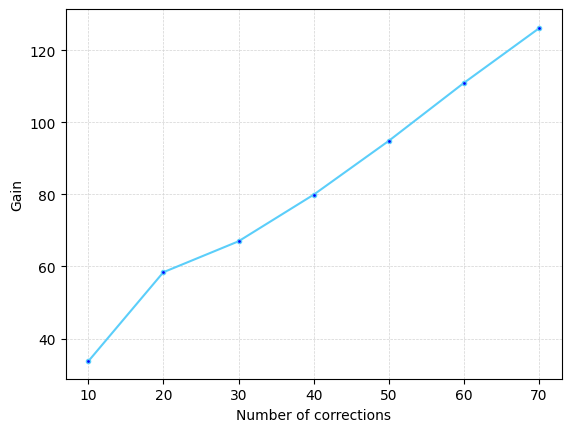

In [16]:
actual_corrections = [10, 20, 30, 40, 50, 60, 70]
gain = [33.66, 58.4, 66.98, 79.91, 94.85, 110.93, 126.09]
error_bar = [0.14, 0.33, 0.37, 0.49, 0.57, 0.62, 0.64]
plt.errorbar(actual_corrections, gain, error_bar, color='#5BCEFA', marker='.', markerfacecolor='blue')
plt.xlabel("Number of corrections")
plt.ylabel("Gain")
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.show()

## Going further

Since the phase kickback process is dependent on the ancilla qubit maintaining its superposition state, amplitude damping errors that occur on the ancilla qubit needs to be accounted for. We can introduce this source of error into our simulation within native Qiskit.


The ancilla qubit will take 1µs to execute, and has a T1 relaxation time of 10µs. The qubit will be re-initialized every parity measurement to minimise the effect of amplitude damping.

In [ ]:
## Demonstration of a circuit that uses noises models
# Repeat circuit as before
qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
anc = AncillaRegister(1)
cr = ClassicalRegister(1)
circ = c2qa.CVCircuit(qmr, anc, cr)

circ.initialize([1, 0], anc[0])
circ.cv_initialize(3, qmr)
circ.h(anc[0])
circ.cv_c_r(pi/2, qmr[0], anc[0])
circ.h(anc[0])
circ.cv_measure(anc, cr)

# Define parameters to calculate gamma. For this example, we make it big enough to see the loss
T1 = 100 # 100us
hgate_duration = 100 # 100us
gamma = 1 - np.exp(-hgate_duration / T1)

# Create noise model
error = amplitude_damping_error(gamma)
noise_model = NoiseModel()
index, _ = circ.find_bit(anc[0])
noise_model.add_quantum_error(error, ['h'], [index])

# Pass the noise model into simulate:
_, _, counts = c2qa.util.simulate(circ, noise_model=noise_model)
print(counts)

### References
[1] Girvin, Steven M. 2021. "Introduction to Quantum Error Correction and Fault Tolerance." arXiv. https://doi.org/10.48550/ARXIV.2111.08894.

[2] Albert, Victor V., and Philippe Faist. 2022. "Binomial Code." The Error Correction Zoo. https://errorcorrectionzoo.org/c/binomial.



#Testing Section

In [ ]:
# ## Average photon number visualisation
# # Plot average photon number data
# plt.figure(figsize=(15,6))
# plt.plot(noise_only_snapshot_timings, noise_only_avg_photon, 
#          label = "No corrections", marker='o', color='#5BCEFA')
# plt.plot(correction_snapshot_timings, correction_avg_photon, 
#          label = "{} corrections/ms".format(num_corr), marker='o', color='#F5A9B8')

# # # Plot correction positions
# # x, y = correction_positions(corr_position_times, correction_avg_fid, correction_snapshot_timings)
# # plt.scatter(x, y, marker = 's', label = "Correction position(s)", color = 'red', zorder=2)

# plt.xlabel("Time (ms)")
# plt.ylabel("Average photon number over {} shots".format(shots))
# plt.title("Simulation of experiment with no correction and {} correction(s)".format(num_corr))
# plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
# plt.legend(loc='upper right')
# plt.show()

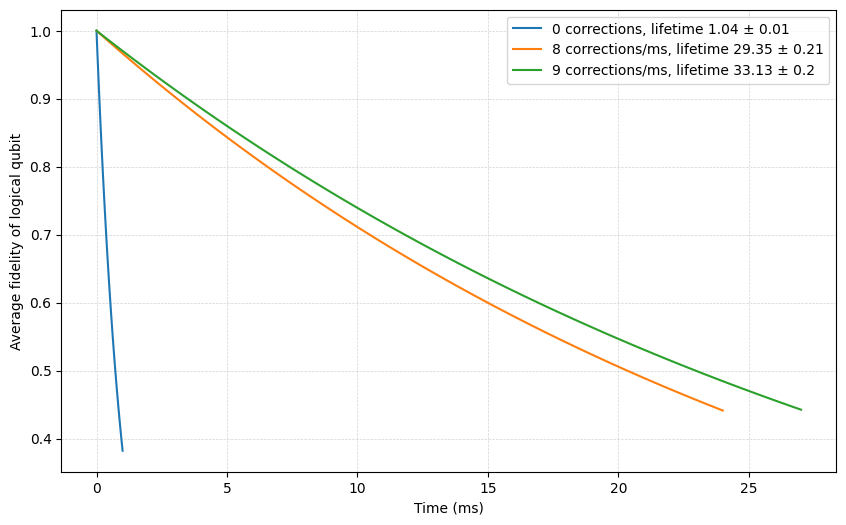

In [75]:
# Testing exponential fit across a variety of corrections (issue here is that I don't know how good the fit is. Case in point, the lifetimes don't necessarily increase with correction no.)
number_corrections = [8, 9]
correction_circuit_time = [8 * 3, 9 * 3]
additional_snapshots = 10
shots = 1024
encoding='logi1' # Input 'logi0' or 'logi1' only

# Find lifetimes
lifetimes = []
lifetime_uncertainty = []
for index, corrections in enumerate(number_corrections):
    correction_avg_fidelity, correction_snapshot_timings, corr_position_times = error_correction_experiment(encoding, corrections, shots, additional_snapshots, correction_circuit_time[index])

    # Fit data and retrieve curve
    lifetime, uncertainty = curve_fitter(correction_snapshot_timings, correction_avg_fidelity)
    lifetimes.append(lifetime)
    lifetime_uncertainty.append(uncertainty)

# Plot data
plt.figure(figsize=(10,6))
plt.plot(np.linspace(0, noise_only_circ_time, 100), np.exp(-np.linspace(0, noise_only_circ_time, 100)/noise_only_lifetime), label="0 corrections, lifetime {} ± {}".format(noise_only_lifetime, noise_lifetime_uncertainty))

for index, lifetime in enumerate(lifetimes):
    curve_timing = np.linspace(0, correction_circuit_time[index], 100)
    plt.plot(curve_timing, np.exp(-curve_timing/lifetime), label="{} corrections/ms, lifetime {} ± {}".format(number_corrections[index], lifetimes[index], lifetime_uncertainty[index]))

plt.xlabel("Time (ms)")
plt.ylabel("Average fidelity of logical qubit")
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.legend()
plt.show()

In [ ]:
## Test two, checking to see how the fit looks like for 15 vs 20 corrections
number_corrections_a = 15
number_corrections_b = 20

additional_snapshots = 10
shots = 1024
total_circuit_time_a = number_corrections_a * 4
total_circuit_time_b = number_corrections_b * 4
######

# Run simulation with and without correction
correction_a_avg_fidelity, correction_a_snapshot_timings = error_correction_experiment(encoding, corrections, shots, additional_snapshots, total_circuit_time_a)
correction_b_avg_fidelity, correction_b_snapshot_timings = error_correction_experiment(encoding, corrections, shots, additional_snapshots, total_circuit_time_b)

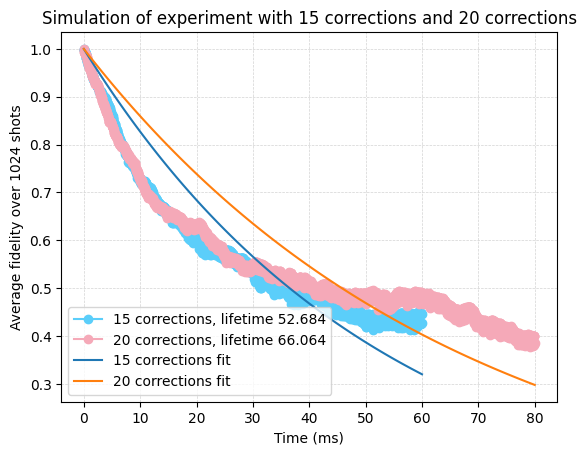

In [ ]:
# Fit data using an exponential decay function
correction_a_lifetime = curve_fitter(correction_a_snapshot_timings, correction_a_avg_fidelity)
correction_b_lifetime = curve_fitter(correction_b_snapshot_timings, correction_b_avg_fidelity)

# Plot data
plt.plot(correction_a_snapshot_timings, correction_a_avg_fidelity, label = "{} corrections, lifetime {}".format(number_corrections_a, round(correction_a_lifetime, 3)), marker='o', color='#5BCEFA')
plt.plot(correction_b_snapshot_timings, correction_b_avg_fidelity, label = "{} corrections, lifetime {}".format(number_corrections_b, round(correction_b_lifetime, 3)), marker='o', color='#F5A9B8')

# Plot curve fits
curve_timing_a = np.linspace(0, total_circuit_time_a, 100)
curve_timing_b = np.linspace(0, total_circuit_time_b, 100)

plt.plot(curve_timing_a, np.exp(-curve_timing_a/correction_a_lifetime), label = "{} corrections fit".format(number_corrections_a))
plt.plot(curve_timing_b, np.exp(-curve_timing_b/correction_b_lifetime), label = "{} corrections fit".format(number_corrections_b))

# Plot correction positions
# xa, ya = correction_positions(correction_a_snapshot_timings, correction_a_avg_fidelity, total_circuit_time_a, additional_snapshots)
# xb, yb = correction_positions(correction_b_snapshot_timings, correction_b_avg_fidelity, total_circuit_time_b, additional_snapshots)
# plt.scatter(xa, ya, marker = 's', label = "Correction position(s)", color = 'red', zorder=2)
# plt.scatter(xb, yb, marker = 's', label = "Correction position(s)", color = 'blue', zorder=2)

plt.xlabel("Time (ms)")
plt.ylabel("Average fidelity over {} shots".format(shots))
plt.title("Simulation of experiment with {} corrections and {} corrections".format(number_corrections_a, number_corrections_b))
plt.grid(color = 'lightgrey', linestyle = 'dashed', linewidth = 0.5)
plt.legend(loc='lower left')
plt.show()

In [ ]:
  # Find no. of actual corrections done
    x, y = correction_positions(corr_position_times, correction_avg_fidelity, correction_snapshot_timings)
    actual_corrections.append(len(x)/correction_circuit_time[index])

In [ ]:
print(teehee)

## Archive of OG error correction experiment code

def error_correction_experiment(logi0: bool, logi1: bool, apply_noise: bool, apply_error_correction: bool):
    ## Circuit simulation
    num_qumodes = 1
    num_qubits_per_qumode = 3

    qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
    anc = AncillaRegister(1)
    cr = ClassicalRegister(1)
    circuit = c2qa.CVCircuit(qmr, anc, cr)

    # 1. State Preparation
    if logi0:
        circuit.cv_initialize(1/np.sqrt(2)*np.array([1,0,0,0, 1]), qmr[0]) # |0_L>
    elif logi1:
        circuit.cv_initialize([0, 0, 1], qmr[0]) # |1_L>
    else:
        raise Exception("The experiment does not support a superposition of logical 0 and logical 1 states.")
    circuit.initialize([1, 0], anc[0])

    # 2. Repeatedly apply noise, parity check + recovery operation
    for i in range(noise_cycles):
        # Save snapshot of statevector for start of every noise cycle
        circuit.save_statevector(label='noise_cycle_{}'.format(i), pershot=True)

        # Apply noise
        if apply_noise:
            circuit.cv_delay(duration=noise_duration_per_cycle, qumode=qmr[0], unit="µs")

        # Photon number parity check. Manually discretize cv_c_r gate by splitting pi/2 rotation into 10 parts of pi/20 rotation, 100ns each
        if apply_error_correction:
            circuit.h(anc[0])
            for i in range(10):
                circuit.cv_c_r(pi/20, qmr[0], anc[0], duration=100, unit="ns")
            circuit.h(anc[0])
            circuit.measure(anc[0], cr[0])

            # Apply recovery operation corresponding to photon parity measurement, reset ancilla qubit and bit
            with circuit.if_test((cr[0], 1)) as else_:
                circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0)
                circuit.reset(anc[0])
            with else_:
                circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0)
        else:
            circuit.cv_delay(duration=3000, qumode=qmr[0], unit="ns")

    # 3. Define noise parameters
    # Noise pass
    noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="µs")

    # Noise model
    T1 = 100 # 100µs
    hgate_duration = 1 # 1µs

    error = amplitude_damping_error(1 - np.exp(-hgate_duration / T1))
    noise_model = NoiseModel()
    index, _ = circuit.find_bit(anc[0])
    noise_model.add_quantum_error(error, ['h'], [index])
    
    # 4. Simulate circuit
    if apply_noise:
        state, result, _ = c2qa.util.simulate(circuit,shots=circuit_repetitions, noise_passes=noise_pass, per_shot_state_vector=True, return_fockcounts=False)
    elif not apply_noise:
        state, result, _ = c2qa.util.simulate(circuit,shots=circuit_repetitions, per_shot_state_vector=True, return_fockcounts=False)
    
    ## Result simulation
    # 1. Process snapshot and final statevectors. Trace out qumode from circuit for both sets of statevectors
    traced_snapshot_density_matrices = []
    for i in range(noise_cycles):
        snapshot_list = result.data()['noise_cycle_{}'.format(i)]

        traced_snapshots = []
        for statevector in snapshot_list:
            traced_snapshots.append(c2qa.util.trace_out_qubits(circuit, statevector))

        traced_snapshot_density_matrices.append(traced_snapshots)

    traced_final_density_matrices = []
    for i in state:
        traced_final_density_matrices.append(c2qa.util.trace_out_qubits(circuit, i))
    
    traced_density_matrices = traced_snapshot_density_matrices + [traced_final_density_matrices]

    # 2. Create statevectors corresponding to our code words
    perf_0 = Statevector([1/np.sqrt(2), 0, 0, 0, 1/np.sqrt(2), 0, 0, 0])
    perf_1 = Statevector([0, 0, 1, 0, 0, 0, 0, 0])

    # 3. Compute fidelity from density matrices
    fidelity_list = []
    for density_matrix_list in traced_density_matrices:
        cycle_list = []
        for matrix in density_matrix_list:
            if logi0:
                cycle_list.append(state_fidelity(matrix, perf_0))
            if logi1:
                cycle_list.append(state_fidelity(matrix, perf_1))

        fidelity_list.append(cycle_list)

    avg_fidelity = [round(sum(cycle)/len(cycle), 4) for cycle in fidelity_list]
    fidelity_sd = [np.std(cycle) for cycle in fidelity_list]

    # 4. Compute avg photon number from density matrices
    ## TODO ##

    return avg_fidelity, fidelity_sd


def curve_fitter(x, y):
    popt, _ = curve_fit(lambda x, b: np.exp(-x/b), x, y)
    x_fitted = np.linspace(np.min(x), np.max(x), 100)
    y_fitted = np.exp(-x_fitted/popt[0])
    
    return x_fitted, y_fitted, popt[0]

NameError: name 'teehee' is not defined

In [ ]:
############## TSETING

## Run this block to load in the functions we need for the simulation

# Runs circuit simulation
def error_correction_experiment(encoding: str, corrections: int, shots: int, additional_snapshots: int=10, total_circuit_time: int=1, apply_noise: bool=True):
    multiplier = total_circuit_time
    total_circuit_time = int(total_circuit_time * 1000) # Code works with microsecond units, but input is in milliseconds
    
    if corrections > 333:
        raise ValueError("Please restrict number of correction procedures to 333 or less")
    photon_loss_rate = 0.0005
    
    if encoding == 'logi0':
        logi0, logi1 = True, False
    elif encoding == 'logi1':
        logi0, logi1 = False, True
    else:
        raise ValueError("Please input either \'logi0\' or \'logi1\' for the encoding")

    num_qumodes = 1
    num_qubits_per_qumode = 3

    qmr = c2qa.QumodeRegister(num_qumodes, num_qubits_per_qumode)
    anc = AncillaRegister(1)
    cr = ClassicalRegister(1)
    circuit = c2qa.CVCircuit(qmr, anc, cr)

    ### 1. State Preparation
    if logi0:
        circuit.cv_initialize(1/np.sqrt(2)*np.array([1,0,0,0, 1]), qmr[0])
    elif logi1:
        circuit.cv_initialize([0, 0, 1], qmr[0])

    circuit.initialize([1, 0], anc[0])

    ### 2. Using instructions stored in schedule, add snapshots, noise, and parity check + recovery operations
    schedule = _circuit_scheduler(corrections * multiplier, additional_snapshots * multiplier, total_circuit_time)
    schedule_copy = list(schedule.items())

    adjustment = 0 # For calculating duration timing
    snapshot_counter = 0 # For tracking number of snapshots taken
    corr_position = [] # For tracking positions at which corrections were finished
    
    for index, (key, value) in enumerate(list(schedule.items())):
        # Instruction at 0µs should always be to take snapshot
        if (key == '0') & (value == 'snapshot'):
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            continue
        elif (key != '0'):
            pass
        else:
            raise Exception("Something seems to have gone wrong here")

        # Calculate delay gate durations using prevkey. Adjustment to duration timing is needed depending on previous instruction
        prevkey, prevvalue = schedule_copy[index - 1]
        delay_dur = int(key) - int(prevkey) + adjustment
        adjustment = 0

        # Apply noise
        circuit.cv_delay(duration=delay_dur, qumode=qmr[0], unit="µs")

        # Apply snapshot only procedure
        if (value == 'snapshot'):
            if (prevvalue == 'correction') & (int(key) == (int(prevkey) + 3)):
                pass
            else:
                circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
                snapshot_counter += 1

        # Apply correction first followed by snapshot 
        elif value == 'correction':
            kt = photon_loss_rate * (delay_dur + 3)
            adjustment = -3

            # Parity check
            #circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            circuit.h(anc[0])
#            for _ in range(10): # Manually discretize cv_c_r gate by splitting one 1µs pi/2 rotation into ten 0.1µs pi/20 rotations
#                circuit.cv_c_r(pi/20, qmr[0], anc[0], duration=0.1, unit="µs")
            circuit.cv_c_r(pi/2, qmr[0], anc[0], duration=1, unit="µs")
            circuit.h(anc[0])
            circuit.measure(anc[0], cr[0])
            #circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")

            # Recovery operation
            with circuit.if_test((cr[0], 1)) as else_:
                circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0)
                circuit.reset(anc[0])
            with else_:
                circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0)
            
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            corr_position.append(int(key) + 3)

        # Apply snapshot first followed by correction, followed by another snapshot
        else:
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            
            adjustment = -3
            kt = photon_loss_rate * (delay_dur + 3)

            # Parity check
            circuit.h(anc[0])
#            for _ in range(10): # Manually discretize cv_c_r gate by splitting one 1µs pi/2 rotation into ten 0.1µs pi/20 rotations
#                circuit.cv_c_r(pi/20, qmr[0], anc[0], duration=0.1, unit="µs")
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            circuit.cv_c_r(pi/2, qmr[0], anc[0], duration=1, unit="µs")
            circuit.cv_delay(duration=1, qumode=qmr[0], unit="µs")
            circuit.h(anc[0])
            circuit.measure(anc[0], cr[0])

            # Recovery operation
            with circuit.if_test((cr[0], 1)) as else_:
                circuit.cv_gate_from_matrix(u_odd, qmr[0], duration=0)
                circuit.reset(anc[0])
            with else_:
                circuit.cv_gate_from_matrix(u_even(kt), qmr[0], duration=0)
                
            circuit.save_statevector(label='snapshot_{}'.format(snapshot_counter), pershot=True)
            snapshot_counter += 1
            corr_position.append(int(key) + 3)

    # Final delay gate
    finalkey, finalvalue = schedule_copy[-1]
    if finalvalue != 'snapshot':
        final_gate_delay = total_circuit_time - int(finalkey) - 3
    else:
        final_gate_delay = total_circuit_time - int(finalkey)
        
    circuit.cv_delay(duration=final_gate_delay, qumode=qmr[0], unit="µs")
    
    ### 3. Define noise parameters
    # Noise pass for qumode photon loss
    noise_pass = c2qa.kraus.PhotonLossNoisePass(photon_loss_rates=photon_loss_rate, circuit=circuit, time_unit="µs")

    # Noise model for hadamard amplitude damping
    T1 = 10 # In µs
    hgate_duration = 1 # In µs
    error = amplitude_damping_error(1 - np.exp(-hgate_duration / T1))

    noise_model = NoiseModel()
    index, _ = circuit.find_bit(anc[0])
    noise_model.add_quantum_error(error, ['h'], [index])
    
    ### 4. Simulate circuit
    if apply_noise:
        state, result, _ = c2qa.util.simulate(circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False, noise_passes=noise_pass) #, noise_model=noise_model)
    elif not apply_noise:
        state, result, _ = c2qa.util.simulate(circuit, shots=shots, per_shot_state_vector=True, return_fockcounts=False)
    
    ### 5. Process data
    # Find avg fidelity and avg prob of each snapshot
    avg_prob, statevector_list = _statevector_processor(encoding, circuit, state, result, snapshot_counter)
    
    # Find exact timing of each snapshot (we have to recalculate because no. of snapshots can change due to scheduling conflicts)
    snapshot_times = _snapshot_timings(schedule, total_circuit_time)

    return avg_prob, statevector_list, snapshot_times, corr_position#, schedule, snapshot_counter, circuit

# Takes results from simulation and processes data to find average fidelity of state
def _statevector_processor(encoding, circuit, state, result, actual_snapshots):
    if encoding == 'logi0':
        logi0, logi1 = True, False
    elif encoding == 'logi1':
        logi0, logi1 = False, True

    # 1. Process snapshot and final statevectors. Trace out qumode from circuit for both sets of statevectors
    traced_snapshot_density_matrices = []
    for i in range(actual_snapshots):
        snapshot_list = result.data()['snapshot_{}'.format(i)]

        traced_snapshots = []
        for statevector in snapshot_list:
            traced_snapshots.append(c2qa.util.trace_out_qubits(circuit, statevector))

        traced_snapshot_density_matrices.append(traced_snapshots)

    traced_final_density_matrices = []
    for i in state:
        traced_final_density_matrices.append(c2qa.util.trace_out_qubits(circuit, i))
    
    traced_density_matrices = traced_snapshot_density_matrices + [traced_final_density_matrices]

    # # 2. Create statevectors corresponding to our code words
    # perf_0 = Statevector([1/np.sqrt(2), 0, 0, 0, 1/np.sqrt(2), 0, 0, 0])
    # perf_1 = Statevector([0, 0, 1, 0, 0, 0, 0, 0])

    # # 3. Compute fidelity from density matrices
    # fidelity_list = []
    statevector_list = []
    for density_matrix_list in traced_density_matrices:
        cycle_list = []
        for matrix in density_matrix_list:
            cycle_list.append(prob_photon_meas(matrix.to_statevector()))

        statevector_list.append(cycle_list)

    avg_prob = [np.mean(i, axis=0) for i in statevector_list]
    #sd_prob = [round(np.std(cycle), 4) for cycle in fidelity_list]

    return avg_prob, statevector_list#, sd_fid

# Function used to determine order and timing in which snapshots and corrections are done.
def _circuit_scheduler(corrections, snapshots, total_time=1000):
    # Schedule snapshots
    snapshot_schedule = {"{}".format(round(i * (total_time/snapshots))): 'snapshot' for i in range(snapshots)}

    # Schedule corrections
    corr_interval = total_time/(1 + corrections)
    correction_schedule = {"{}".format(int((i + 1) * corr_interval)): 'correction' for i in range(corrections)}
        
    # Merge the two dicts from above. If duplicate keys exist then concatenate values together.
    try:
        unsorted_merged_schedule = {**snapshot_schedule, **correction_schedule}

        for key, value in list(snapshot_schedule.items()):
            if key in list(correction_schedule.keys()):
                unsorted_merged_schedule[key] = '{}'.format(value + '+' + correction_schedule[key])
            else:
                pass
    # If correction_schedule doesn't exist, return snapshot_schedule
    except:
        return snapshot_schedule
    
    # Sort merged dicts
    merged_schedule = {key:value for key, value in sorted(unsorted_merged_schedule.items(), key=lambda item: int(item[0]))}

    # Ensure that all corrections happen at least 3µs before each snapshot
    # but if two successive corrections happen within 3µs of each other, drop the second correction
    DictItems = list(merged_schedule.items())
    unsorted_cleaned_schedule = dict(merged_schedule)
    for index, (key, value) in enumerate(DictItems):
        # index == 0 case
        if index == 0:
            nextkey, _ = DictItems[index + 1]
            if (value == 'correction') & (int(key) + 3 > int(nextkey)):
                unsorted_cleaned_schedule['{}'.format(str(int(nextkey) - 3))] = unsorted_cleaned_schedule.pop('{}'.format(key))
        # index != 0 case
        else:
            # Automatically break loop when we get to last element of dictionary
            try:
                nextkey, _ = DictItems[index + 1]
                prevkey, _ = DictItems[index - 1]
            except:
                break
            
            if (value == 'correction') & (int(key) + 3 > int(nextkey)) & (int(prevkey) < int(key) - 3):
                unsorted_cleaned_schedule['{}'.format(str(int(nextkey) - 3))] = unsorted_cleaned_schedule.pop('{}'.format(key))
            elif (value == 'correction') & (int(key) + 3 > int(nextkey)):
                unsorted_cleaned_schedule.pop('{}'.format(key))
                print("Due to scheduling conflicts, a correction scheduled at {}µs will be dropped".format(key))

    # Sort overall_schedule
    cleaned_schedule = {key:value for key, value in sorted(unsorted_cleaned_schedule.items(), key=lambda item: int(item[0]))}

    return cleaned_schedule

# Function for extracting snapshot timings (in ms)
def _snapshot_timings(schedule, total_circuit_time):
    timings = []
    sch_copy = list(schedule.items())
    prevkey, prevvalue = 0, 0 # Just so that first iteration doesn't throw an error
    
    for index, (key, value) in enumerate(list(schedule.items())):
        if index != 0:
            prevkey, prevvalue = sch_copy[index - 1]
        
        if value == 'snapshot':
            if (prevvalue == 'correction') & (int(key) == (int(prevkey) + 3)):
                pass
            else:
                timings.append(int(key)/1000)
            
        elif value =='correction':
            timings.append((int(key) + 3)/1000)
        else:
            timings.append(int(key)/1000)
            timings.append((int(key) + 3)/1000)
            
    timings.append(total_circuit_time/1000)
    
    return timings

# Function for extracting positions where corrections were done
def correction_positions(corr_positions, correction_avg_fidelity, correction_snapshot_timings):
    corr_time = [key/1000 for key in corr_positions]
    corr_fid = [correction_avg_fidelity[correction_snapshot_timings.index(timing)] for timing in corr_time]
    
    return corr_time, corr_fid

# Function for fitting exponential curve
def curve_fitter(x, y):
    popt, pcov = curve_fit(lambda x, b: np.exp(-x/b), x, y)
    sigma = np.sqrt(np.diag(pcov))
    
    lifetime = round(popt[0], 2)
    uncertainty = round(sigma[0], 2)
    
    return lifetime, uncertainty


################

In [ ]:
## TESTING ### 
number_corrections = 10 # per ms
additional_snapshots = 10 # per ms

noise_only_circuit_time = 1 # ms
correction_circuit_time = 30 # ms

shots = 1024
encoding='logi1' # Input 'logi0' or 'logi1' only
## 

# Run simulation with and without correction
avg_prob, noise_only_statevectors, noise_only_snapshot_timings, _ = error_correction_experiment(encoding, 0, shots, additional_snapshots, noise_only_circuit_time)
corr_avg_prob, correction_statevectors, correction_snapshot_timings, corr_position_times = error_correction_experiment(encoding, number_corrections, shots, additional_snapshots, correction_circuit_time)